In [1]:
import sys
sys.path.insert(0, '../../pyLDLE2/')

import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
import scipy as sp

import ConnectionNetworkX_v2 as cnx

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from pyLDLE2 import datasets, visualize_

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX_v2' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/ConnectionNetworkX_v2.py'>

# Load puppets data and build connection graph

In [3]:
data_dir = "/data2/dhruv/PuppetsData/"

n_images = 1000

X, labelsMat, _, _ = datasets.Datasets().puppets_data(data_dir)

Applying PCA
sum(explained_variance_ratio): 0.9815712482774274
X.shape =  (8100, 100)


In [4]:
inds = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(inds)
inds = inds[:n_images]
X = X[:n_images,:]

In [5]:
X.shape

(1000, 100)

#  build connection graph

In [6]:
k = 13
d = 2

CG = cnx.cnxFromData(X, k=k, d=d)

local_opts['k_nn0'] = 49 is created.
Options provided:
local_opts:
{
    "Atilde_method": "LDLE_1",
    "N": 100,
    "U_method": "k_nn",
    "algo": "LPCA",
    "alpha": 1,
    "debug": true,
    "delta": 0.9,
    "gl_type": "unnorm",
    "k": 13,
    "k_nn": 49,
    "k_nn0": 49,
    "k_tune": 7,
    "lambda1_decay": 0.75,
    "lambda1_init": 8,
    "lambda1_min": 0.001,
    "max_iter": 300,
    "max_sparsity": 0.9,
    "metric": "euclidean",
    "n_proc": 32,
    "p": 0.99,
    "power": 5,
    "pp_n_thresh": 32,
    "radius": 0.5,
    "reg": 0.0,
    "scale_by": "gamma",
    "tau": 50,
    "to_postprocess": true,
    "tuning": "self",
    "verbose": true
}
intermed_opts:
{
    "algo": "best",
    "debug": true,
    "eta_max": 1,
    "eta_min": 5,
    "len_S_thresh": 256,
    "local_algo": "LPCA",
    "n_proc": 32,
    "n_times": 4,
    "verbose": true
}
global_opts:
{
    "add_dim": false,
    "align_transform": "rigid",
    "align_w_parent_only": true,
    "alpha": 0.3,
    "beta": 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 202.87it/s]


Proportion of edges which were removed due to remoteness:  0.0533878010987463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.35it/s]


[-0.32904379 -0.2923801  -0.23663331 -0.21386897 -0.16174801  0.10081727
 -0.08556053  0.06469897  0.04953724 -0.04455307]
MOST LIKELY INCONSISTENT: |lambda_min| >= 1e-8. 


# Set B, w, mu, nu, c

In [13]:
d = INTRINSIC_DIMENSION
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
W = np.ones(B.shape[0]//d).astype('float32')

np.random.seed(42)
source = np.random.randint(0, CG.number_of_nodes())
dest = np.random.randint(0, CG.number_of_nodes())

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = [[1],[1]]
nu[dest * d: (dest + 1) * d, :] = [[1],[1]]

c = (mu - nu)

In [14]:
c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(c.flatten() - B.T.dot(c_sol).flatten())

/tmp/ipykernel_38161/426106341.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)


1.1679892834487842e-14

In [15]:
learning_rate = 0.01
alpha = 0.1
n_epochs = 20000

B = torch.tensor(B.toarray())
w = torch.tensor(W)
c = torch.tensor(c.astype('float32'))
#phi0 = -np.matmul(np.linalg.pinv(np.matmul(B.T, B)), c)
phi0 = None

if phi0 is not None:
    print('Initial loss:', cnx.loss_fn(torch.tensor(phi0), B, w, c))

phi = cnx.optimize(B, w, c, alpha, learning_rate, n_epochs, phi0 = phi0)

epoch: 0, loss: 128505.085938, loss0: -2.059458, loss1: 25701.429688
epoch: 10, loss: 101809.195312, loss0: -2.056841, loss1: 20362.250000
epoch: 20, loss: 80101.640625, loss0: -2.028138, loss1: 16020.734375
epoch: 30, loss: 62873.261719, loss0: -1.954301, loss1: 12575.042969
epoch: 40, loss: 49388.796875, loss0: -1.864071, loss1: 9878.131836
epoch: 50, loss: 38900.707031, loss0: -1.782274, loss1: 7780.497559
epoch: 60, loss: 30758.804688, loss0: -1.713821, loss1: 6152.103516
epoch: 70, loss: 24428.857422, loss0: -1.651676, loss1: 4886.102051
epoch: 80, loss: 19492.552734, loss0: -1.586066, loss1: 3898.827637
epoch: 90, loss: 15627.875000, loss0: -1.511129, loss1: 3125.877197
epoch: 100, loss: 12588.080078, loss0: -1.431453, loss1: 2517.902344
epoch: 110, loss: 10186.925781, loss0: -1.355388, loss1: 2037.656250
epoch: 120, loss: 8283.127930, loss0: -1.286948, loss1: 1656.883057
epoch: 130, loss: 6766.852539, loss0: -1.223682, loss1: 1353.615234
epoch: 140, loss: 5553.545410, loss0: -1.

epoch: 1280, loss: -1.568371, loss0: -1.776955, loss1: 0.041717
epoch: 1290, loss: -1.587938, loss0: -1.785874, loss1: 0.039587
epoch: 1300, loss: -1.606772, loss0: -1.794712, loss1: 0.037588
epoch: 1310, loss: -1.624933, loss0: -1.803524, loss1: 0.035718
epoch: 1320, loss: -1.642428, loss0: -1.812017, loss1: 0.033918
epoch: 1330, loss: -1.659284, loss0: -1.820262, loss1: 0.032196
epoch: 1340, loss: -1.675557, loss0: -1.828646, loss1: 0.030618
epoch: 1350, loss: -1.691248, loss0: -1.836903, loss1: 0.029131
epoch: 1360, loss: -1.706392, loss0: -1.845120, loss1: 0.027746
epoch: 1370, loss: -1.721027, loss0: -1.853269, loss1: 0.026448
epoch: 1380, loss: -1.735207, loss0: -1.861350, loss1: 0.025229
epoch: 1390, loss: -1.748979, loss0: -1.869425, loss1: 0.024089
epoch: 1400, loss: -1.762386, loss0: -1.877508, loss1: 0.023025
epoch: 1410, loss: -1.775459, loss0: -1.885600, loss1: 0.022028
epoch: 1420, loss: -1.788230, loss0: -1.893633, loss1: 0.021081
epoch: 1430, loss: -1.800725, loss0: -1.

epoch: 2570, loss: -2.771150, loss0: -2.799050, loss1: 0.005580
epoch: 2580, loss: -2.778448, loss0: -2.806019, loss1: 0.005514
epoch: 2590, loss: -2.785730, loss0: -2.813127, loss1: 0.005479
epoch: 2600, loss: -2.793015, loss0: -2.820297, loss1: 0.005456
epoch: 2610, loss: -2.800313, loss0: -2.827510, loss1: 0.005439
epoch: 2620, loss: -2.807626, loss0: -2.834770, loss1: 0.005429
epoch: 2630, loss: -2.814958, loss0: -2.842061, loss1: 0.005421
epoch: 2640, loss: -2.822311, loss0: -2.849371, loss1: 0.005412
epoch: 2650, loss: -2.829685, loss0: -2.856709, loss1: 0.005405
epoch: 2660, loss: -2.837071, loss0: -2.864072, loss1: 0.005400
epoch: 2670, loss: -2.844477, loss0: -2.871438, loss1: 0.005392
epoch: 2680, loss: -2.851907, loss0: -2.878820, loss1: 0.005382
epoch: 2690, loss: -2.859348, loss0: -2.886226, loss1: 0.005376
epoch: 2700, loss: -2.866786, loss0: -2.893582, loss1: 0.005359
epoch: 2710, loss: -2.874230, loss0: -2.900965, loss1: 0.005347
epoch: 2720, loss: -2.881677, loss0: -2.

epoch: 3860, loss: -3.767079, loss0: -3.787777, loss1: 0.004140
epoch: 3870, loss: -3.775308, loss0: -3.796005, loss1: 0.004139
epoch: 3880, loss: -3.783559, loss0: -3.804253, loss1: 0.004139
epoch: 3890, loss: -3.791837, loss0: -3.812533, loss1: 0.004139
epoch: 3900, loss: -3.800137, loss0: -3.820837, loss1: 0.004140
epoch: 3910, loss: -3.808455, loss0: -3.829157, loss1: 0.004141
epoch: 3920, loss: -3.816797, loss0: -3.837473, loss1: 0.004135
epoch: 3930, loss: -3.825142, loss0: -3.845726, loss1: 0.004117
epoch: 3940, loss: -3.833457, loss0: -3.853986, loss1: 0.004106
epoch: 3950, loss: -3.841758, loss0: -3.862282, loss1: 0.004105
epoch: 3960, loss: -3.850075, loss0: -3.870593, loss1: 0.004104
epoch: 3970, loss: -3.858389, loss0: -3.878864, loss1: 0.004095
epoch: 3980, loss: -3.866709, loss0: -3.887125, loss1: 0.004083
epoch: 3990, loss: -3.875042, loss0: -3.895397, loss1: 0.004071
epoch: 4000, loss: -3.883390, loss0: -3.903608, loss1: 0.004044
epoch: 4010, loss: -3.891705, loss0: -3.

epoch: 5150, loss: -4.833652, loss0: -4.852695, loss1: 0.003808
epoch: 5160, loss: -4.841291, loss0: -4.860352, loss1: 0.003812
epoch: 5170, loss: -4.848948, loss0: -4.867998, loss1: 0.003810
epoch: 5180, loss: -4.856622, loss0: -4.875668, loss1: 0.003809
epoch: 5190, loss: -4.864313, loss0: -4.883371, loss1: 0.003812
epoch: 5200, loss: -4.872016, loss0: -4.891041, loss1: 0.003805
epoch: 5210, loss: -4.879733, loss0: -4.898763, loss1: 0.003806
epoch: 5220, loss: -4.887457, loss0: -4.906483, loss1: 0.003805
epoch: 5230, loss: -4.895199, loss0: -4.914232, loss1: 0.003807
epoch: 5240, loss: -4.902929, loss0: -4.921990, loss1: 0.003812
epoch: 5250, loss: -4.910667, loss0: -4.929707, loss1: 0.003808
epoch: 5260, loss: -4.918411, loss0: -4.937479, loss1: 0.003814
epoch: 5270, loss: -4.926146, loss0: -4.945171, loss1: 0.003805
epoch: 5280, loss: -4.933892, loss0: -4.952913, loss1: 0.003804
epoch: 5290, loss: -4.941658, loss0: -4.960684, loss1: 0.003805
epoch: 5300, loss: -4.949431, loss0: -4.

epoch: 6440, loss: -5.804802, loss0: -5.826709, loss1: 0.004381
epoch: 6450, loss: -5.811630, loss0: -5.833561, loss1: 0.004386
epoch: 6460, loss: -5.818467, loss0: -5.840442, loss1: 0.004395
epoch: 6470, loss: -5.825296, loss0: -5.847292, loss1: 0.004399
epoch: 6480, loss: -5.832173, loss0: -5.854139, loss1: 0.004393
epoch: 6490, loss: -5.839056, loss0: -5.861061, loss1: 0.004401
epoch: 6500, loss: -5.845947, loss0: -5.867910, loss1: 0.004393
epoch: 6510, loss: -5.852829, loss0: -5.874759, loss1: 0.004386
epoch: 6520, loss: -5.859722, loss0: -5.881641, loss1: 0.004384
epoch: 6530, loss: -5.866609, loss0: -5.888492, loss1: 0.004377
epoch: 6540, loss: -5.873477, loss0: -5.895398, loss1: 0.004384
epoch: 6550, loss: -5.880333, loss0: -5.902291, loss1: 0.004392
epoch: 6560, loss: -5.887187, loss0: -5.909136, loss1: 0.004390
epoch: 6570, loss: -5.894062, loss0: -5.915983, loss1: 0.004384
epoch: 6580, loss: -5.900949, loss0: -5.922825, loss1: 0.004375
epoch: 6590, loss: -5.907848, loss0: -5.

epoch: 7730, loss: -6.693342, loss0: -6.717656, loss1: 0.004863
epoch: 7740, loss: -6.700011, loss0: -6.723869, loss1: 0.004772
epoch: 7750, loss: -6.706630, loss0: -6.730448, loss1: 0.004764
epoch: 7760, loss: -6.713289, loss0: -6.737147, loss1: 0.004772
epoch: 7770, loss: -6.719853, loss0: -6.743394, loss1: 0.004708
epoch: 7780, loss: -6.726531, loss0: -6.751441, loss1: 0.004982
epoch: 7790, loss: -6.733135, loss0: -6.757885, loss1: 0.004950
epoch: 7800, loss: -6.739780, loss0: -6.764414, loss1: 0.004927
epoch: 7810, loss: -6.746301, loss0: -6.771884, loss1: 0.005117
epoch: 7820, loss: -6.752958, loss0: -6.776793, loss1: 0.004767
epoch: 7830, loss: -6.759633, loss0: -6.784394, loss1: 0.004952
epoch: 7840, loss: -6.766136, loss0: -6.791537, loss1: 0.005080
epoch: 7850, loss: -6.772636, loss0: -6.796704, loss1: 0.004813
epoch: 7860, loss: -6.779192, loss0: -6.804140, loss1: 0.004990
epoch: 7870, loss: -6.785662, loss0: -6.810780, loss1: 0.005024
epoch: 7880, loss: -6.792088, loss0: -6.

epoch: 9060, loss: -7.418788, loss0: -7.446043, loss1: 0.005451
epoch: 9070, loss: -7.422872, loss0: -7.449719, loss1: 0.005369
epoch: 9080, loss: -7.426926, loss0: -7.453915, loss1: 0.005398
epoch: 9090, loss: -7.430785, loss0: -7.458592, loss1: 0.005561
epoch: 9100, loss: -7.434850, loss0: -7.461124, loss1: 0.005255
epoch: 9110, loss: -7.438846, loss0: -7.465444, loss1: 0.005320
epoch: 9120, loss: -7.442664, loss0: -7.469227, loss1: 0.005313
epoch: 9130, loss: -7.446749, loss0: -7.474635, loss1: 0.005577
epoch: 9140, loss: -7.450708, loss0: -7.477904, loss1: 0.005439
epoch: 9150, loss: -7.454648, loss0: -7.481140, loss1: 0.005298
epoch: 9160, loss: -7.458541, loss0: -7.485894, loss1: 0.005471
epoch: 9170, loss: -7.462218, loss0: -7.490180, loss1: 0.005592
epoch: 9180, loss: -7.466010, loss0: -7.493253, loss1: 0.005449
epoch: 9190, loss: -7.469934, loss0: -7.497078, loss1: 0.005429
epoch: 9200, loss: -7.473593, loss0: -7.501418, loss1: 0.005565
epoch: 9210, loss: -7.477326, loss0: -7.

epoch: 10360, loss: -7.785603, loss0: -7.813623, loss1: 0.005604
epoch: 10370, loss: -7.787291, loss0: -7.814046, loss1: 0.005351
epoch: 10380, loss: -7.789142, loss0: -7.816253, loss1: 0.005422
epoch: 10390, loss: -7.790703, loss0: -7.818964, loss1: 0.005652
epoch: 10400, loss: -7.792410, loss0: -7.819021, loss1: 0.005322
epoch: 10410, loss: -7.793981, loss0: -7.820936, loss1: 0.005391
epoch: 10420, loss: -7.795546, loss0: -7.822761, loss1: 0.005443
epoch: 10430, loss: -7.797038, loss0: -7.823872, loss1: 0.005367
epoch: 10440, loss: -7.798319, loss0: -7.826340, loss1: 0.005604
epoch: 10450, loss: -7.800154, loss0: -7.827491, loss1: 0.005467
epoch: 10460, loss: -7.801715, loss0: -7.829748, loss1: 0.005607
epoch: 10470, loss: -7.803232, loss0: -7.830049, loss1: 0.005363
epoch: 10480, loss: -7.804679, loss0: -7.832721, loss1: 0.005608
epoch: 10490, loss: -7.806304, loss0: -7.832932, loss1: 0.005326
epoch: 10500, loss: -7.807939, loss0: -7.835525, loss1: 0.005517
epoch: 10510, loss: -7.80

epoch: 11660, loss: -7.922658, loss0: -7.950510, loss1: 0.005570
epoch: 11670, loss: -7.923054, loss0: -7.951946, loss1: 0.005778
epoch: 11680, loss: -7.923851, loss0: -7.952315, loss1: 0.005693
epoch: 11690, loss: -7.924664, loss0: -7.952858, loss1: 0.005639
epoch: 11700, loss: -7.925169, loss0: -7.954730, loss1: 0.005912
epoch: 11710, loss: -7.925796, loss0: -7.955124, loss1: 0.005866
epoch: 11720, loss: -7.926308, loss0: -7.954522, loss1: 0.005643
epoch: 11730, loss: -7.926852, loss0: -7.955124, loss1: 0.005654
epoch: 11740, loss: -7.927381, loss0: -7.954914, loss1: 0.005507
epoch: 11750, loss: -7.927658, loss0: -7.957996, loss1: 0.006068
epoch: 11760, loss: -7.928405, loss0: -7.955637, loss1: 0.005446
epoch: 11770, loss: -7.929204, loss0: -7.958130, loss1: 0.005785
epoch: 11780, loss: -7.929676, loss0: -7.959514, loss1: 0.005968
epoch: 11790, loss: -7.930013, loss0: -7.958041, loss1: 0.005606
epoch: 11800, loss: -7.930703, loss0: -7.959402, loss1: 0.005740
epoch: 11810, loss: -7.93

epoch: 12950, loss: -7.968108, loss0: -7.996877, loss1: 0.005754
epoch: 12960, loss: -7.968687, loss0: -7.997550, loss1: 0.005772
epoch: 12970, loss: -7.968770, loss0: -7.998533, loss1: 0.005953
epoch: 12980, loss: -7.969154, loss0: -7.997814, loss1: 0.005732
epoch: 12990, loss: -7.969395, loss0: -7.998343, loss1: 0.005790
epoch: 13000, loss: -7.969265, loss0: -7.999136, loss1: 0.005974
epoch: 13010, loss: -7.969632, loss0: -7.998077, loss1: 0.005689
epoch: 13020, loss: -7.969485, loss0: -8.000322, loss1: 0.006168
epoch: 13030, loss: -7.969751, loss0: -7.999363, loss1: 0.005923
epoch: 13040, loss: -7.970168, loss0: -7.999036, loss1: 0.005774
epoch: 13050, loss: -7.970126, loss0: -7.999756, loss1: 0.005926
epoch: 13060, loss: -7.966607, loss0: -7.999841, loss1: 0.006647
epoch: 13070, loss: -7.967984, loss0: -7.997407, loss1: 0.005885
epoch: 13080, loss: -7.969539, loss0: -7.998055, loss1: 0.005703
epoch: 13090, loss: -7.970448, loss0: -7.999813, loss1: 0.005873
epoch: 13100, loss: -7.97

epoch: 14250, loss: -7.976966, loss0: -8.005473, loss1: 0.005701
epoch: 14260, loss: -7.975153, loss0: -8.006742, loss1: 0.006318
epoch: 14270, loss: -7.976872, loss0: -8.006793, loss1: 0.005984
epoch: 14280, loss: -7.976289, loss0: -8.004593, loss1: 0.005661
epoch: 14290, loss: -7.976731, loss0: -8.006335, loss1: 0.005921
epoch: 14300, loss: -7.976810, loss0: -8.007618, loss1: 0.006162
epoch: 14310, loss: -7.977481, loss0: -8.007837, loss1: 0.006071
epoch: 14320, loss: -7.977757, loss0: -8.008390, loss1: 0.006127
epoch: 14330, loss: -7.977939, loss0: -8.007412, loss1: 0.005895
epoch: 14340, loss: -7.977675, loss0: -8.009243, loss1: 0.006314
epoch: 14350, loss: -7.977644, loss0: -8.006504, loss1: 0.005772
epoch: 14360, loss: -7.976808, loss0: -8.004983, loss1: 0.005635
epoch: 14370, loss: -7.976617, loss0: -8.007530, loss1: 0.006183
epoch: 14380, loss: -7.976163, loss0: -8.005915, loss1: 0.005950
epoch: 14390, loss: -7.974639, loss0: -8.005858, loss1: 0.006244
epoch: 14400, loss: -7.97

epoch: 15550, loss: -7.978679, loss0: -8.008274, loss1: 0.005919
epoch: 15560, loss: -7.977932, loss0: -8.007826, loss1: 0.005979
epoch: 15570, loss: -7.978475, loss0: -8.006825, loss1: 0.005670
epoch: 15580, loss: -7.978538, loss0: -8.009377, loss1: 0.006168
epoch: 15590, loss: -7.977913, loss0: -8.007735, loss1: 0.005964
epoch: 15600, loss: -7.973560, loss0: -8.002540, loss1: 0.005796
epoch: 15610, loss: -7.975381, loss0: -8.007033, loss1: 0.006331
epoch: 15620, loss: -7.976442, loss0: -8.006292, loss1: 0.005970
epoch: 15630, loss: -7.977429, loss0: -8.007773, loss1: 0.006069
epoch: 15640, loss: -7.978028, loss0: -8.008942, loss1: 0.006183
epoch: 15650, loss: -7.978293, loss0: -8.008231, loss1: 0.005988
epoch: 15660, loss: -7.978324, loss0: -8.008414, loss1: 0.006018
epoch: 15670, loss: -7.978342, loss0: -8.006927, loss1: 0.005717
epoch: 15680, loss: -7.977966, loss0: -8.007790, loss1: 0.005965
epoch: 15690, loss: -7.978077, loss0: -8.009525, loss1: 0.006290
epoch: 15700, loss: -7.97

epoch: 16840, loss: -7.977529, loss0: -8.006618, loss1: 0.005818
epoch: 16850, loss: -7.977720, loss0: -8.006760, loss1: 0.005808
epoch: 16860, loss: -7.976940, loss0: -8.009459, loss1: 0.006504
epoch: 16870, loss: -7.976896, loss0: -8.007595, loss1: 0.006140
epoch: 16880, loss: -7.976359, loss0: -8.006403, loss1: 0.006009
epoch: 16890, loss: -7.975723, loss0: -8.009572, loss1: 0.006770
epoch: 16900, loss: -7.976300, loss0: -8.007529, loss1: 0.006246
epoch: 16910, loss: -7.975833, loss0: -8.008664, loss1: 0.006566
epoch: 16920, loss: -7.974365, loss0: -8.007367, loss1: 0.006600
epoch: 16930, loss: -7.975849, loss0: -8.005537, loss1: 0.005938
epoch: 16940, loss: -7.974798, loss0: -8.005777, loss1: 0.006196
epoch: 16950, loss: -7.975022, loss0: -8.005124, loss1: 0.006020
epoch: 16960, loss: -7.973966, loss0: -8.006554, loss1: 0.006518
epoch: 16970, loss: -7.973307, loss0: -8.004602, loss1: 0.006259
epoch: 16980, loss: -7.971944, loss0: -8.003128, loss1: 0.006237
epoch: 16990, loss: -7.96

epoch: 18140, loss: -7.973866, loss0: -8.005459, loss1: 0.006318
epoch: 18150, loss: -7.974337, loss0: -8.005952, loss1: 0.006323
epoch: 18160, loss: -7.973675, loss0: -8.006313, loss1: 0.006528
epoch: 18170, loss: -7.972782, loss0: -8.004197, loss1: 0.006283
epoch: 18180, loss: -7.974000, loss0: -8.001947, loss1: 0.005590
epoch: 18190, loss: -7.975344, loss0: -8.005350, loss1: 0.006001
epoch: 18200, loss: -7.973597, loss0: -8.004003, loss1: 0.006081
epoch: 18210, loss: -7.974678, loss0: -8.006457, loss1: 0.006356
epoch: 18220, loss: -7.973753, loss0: -8.006157, loss1: 0.006481
epoch: 18230, loss: -7.975804, loss0: -8.006199, loss1: 0.006079
epoch: 18240, loss: -7.976297, loss0: -8.007760, loss1: 0.006293
epoch: 18250, loss: -7.976721, loss0: -8.008895, loss1: 0.006435
epoch: 18260, loss: -7.977340, loss0: -8.007682, loss1: 0.006068
epoch: 18270, loss: -7.977650, loss0: -8.008671, loss1: 0.006204
epoch: 18280, loss: -7.975633, loss0: -8.007382, loss1: 0.006350
epoch: 18290, loss: -7.97

epoch: 19420, loss: -7.977356, loss0: -8.005192, loss1: 0.005567
epoch: 19430, loss: -7.977201, loss0: -8.007735, loss1: 0.006107
epoch: 19440, loss: -7.976598, loss0: -8.007640, loss1: 0.006208
epoch: 19450, loss: -7.977087, loss0: -8.008467, loss1: 0.006276
epoch: 19460, loss: -7.975661, loss0: -8.005187, loss1: 0.005905
epoch: 19470, loss: -7.976149, loss0: -8.006437, loss1: 0.006058
epoch: 19480, loss: -7.977392, loss0: -8.008218, loss1: 0.006165
epoch: 19490, loss: -7.977072, loss0: -8.007511, loss1: 0.006088
epoch: 19500, loss: -7.975778, loss0: -8.007143, loss1: 0.006273
epoch: 19510, loss: -7.974313, loss0: -8.004284, loss1: 0.005994
epoch: 19520, loss: -7.973357, loss0: -8.006630, loss1: 0.006655
epoch: 19530, loss: -7.975523, loss0: -8.007450, loss1: 0.006385
epoch: 19540, loss: -7.976495, loss0: -8.006325, loss1: 0.005966
epoch: 19550, loss: -7.976909, loss0: -8.006227, loss1: 0.005864
epoch: 19560, loss: -7.976696, loss0: -8.005901, loss1: 0.005841
epoch: 19570, loss: -7.97

In [25]:
edge_score = cnx.active_edges(phi, B, w, c)
#edge_score = nabla_phi_norm(phi, B)
edge_score = edge_score.detach().numpy()

In [26]:
J_opt = cnx.optimal_J(phi, B, w, alpha, d)

In [27]:
err = (torch.matmul(B.T, J_opt.flatten()[:,None]) - c).detach().numpy()

In [28]:
np.mean(np.abs(err))

0.00822458

<IPython.core.display.Javascript object>


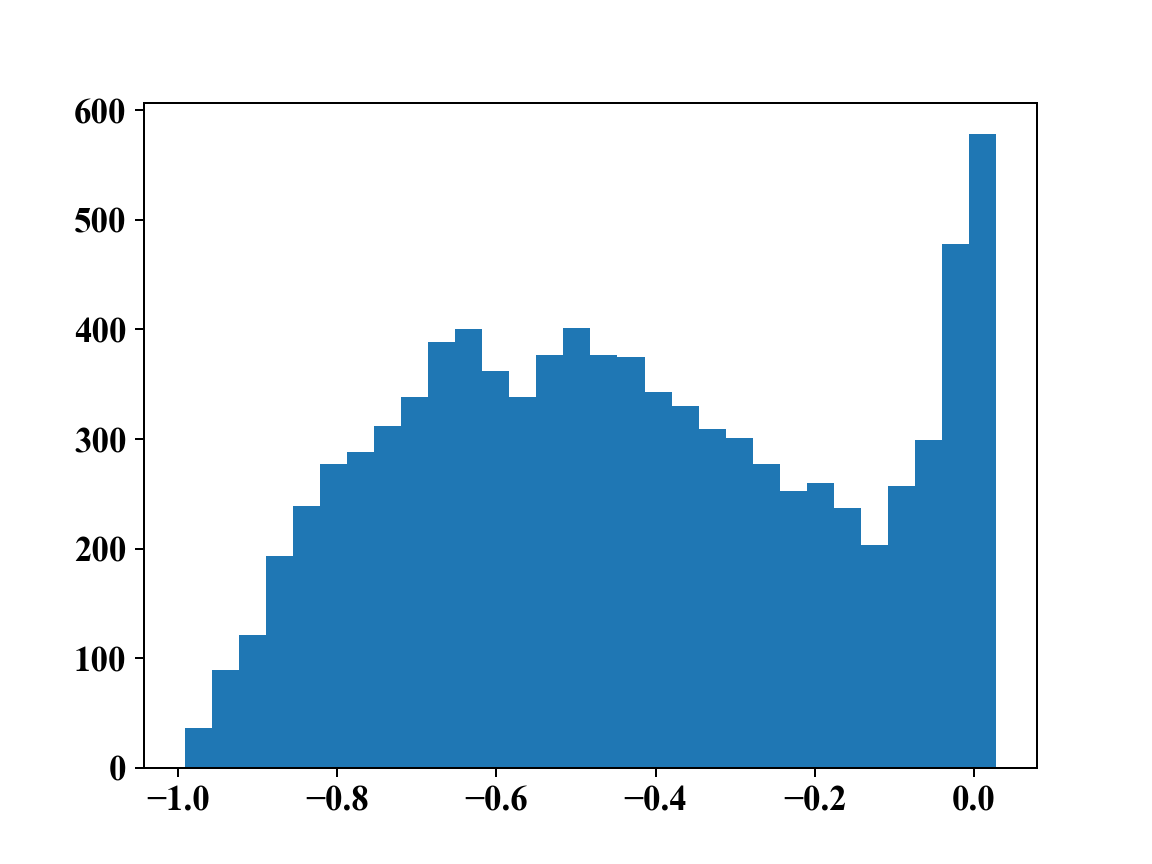

In [29]:
plt.figure()
plt.hist(edge_score, bins=30)
plt.show()

In [30]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
#fit_obj = LocallyLinearEmbedding(n_components=d, n_neighbors=7, method='ltsa')
fit_obj = Isomap(n_components=d, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
embedding = fit_obj.fit_transform(X)

<IPython.core.display.Javascript object>


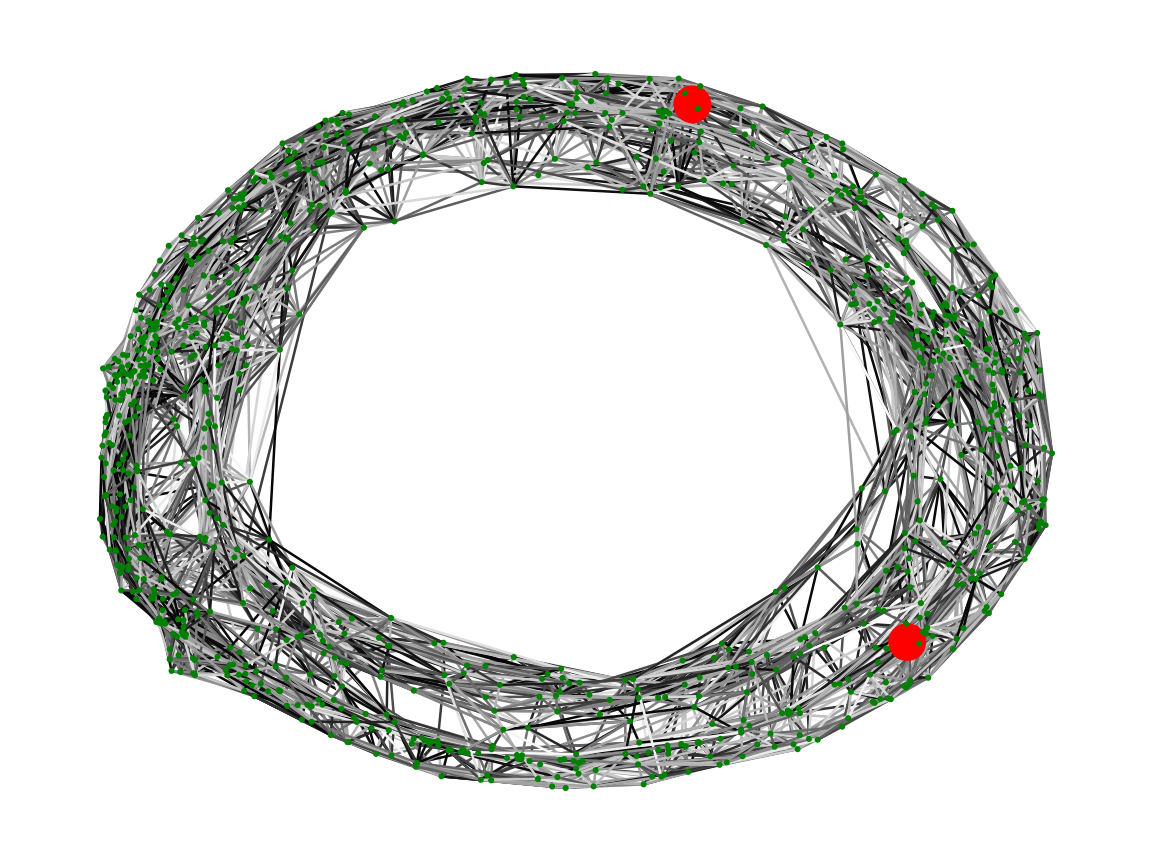

In [22]:
%matplotlib notebook
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

Bphi = torch.matmul(B, phi).reshape((w.shape[0],-1)).detach().numpy()
edge_color = np.linalg.norm(Bphi, axis=1)
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)

<IPython.core.display.Javascript object>


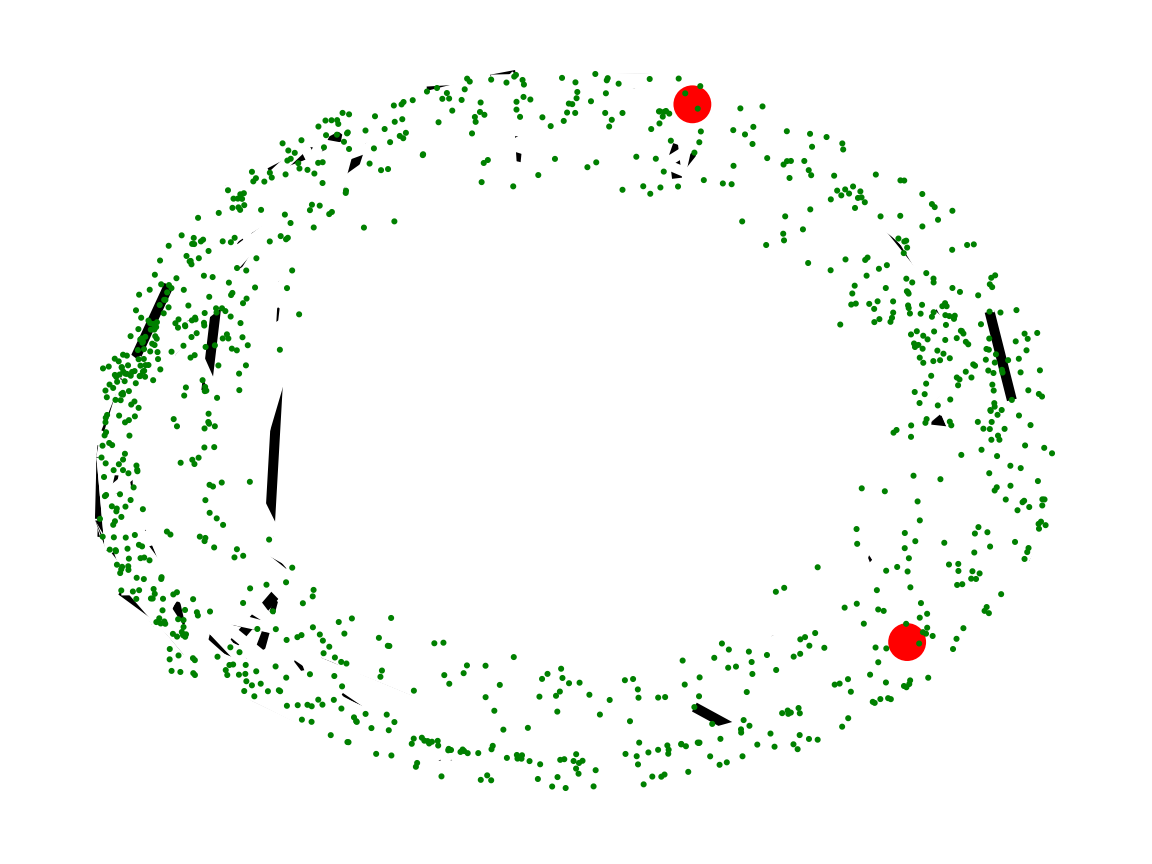

In [23]:
%matplotlib notebook
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

edge_color = (np.linalg.norm(J_opt.detach().numpy(), axis=1) > 0).astype('float32')
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 4,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)


<IPython.core.display.Javascript object>


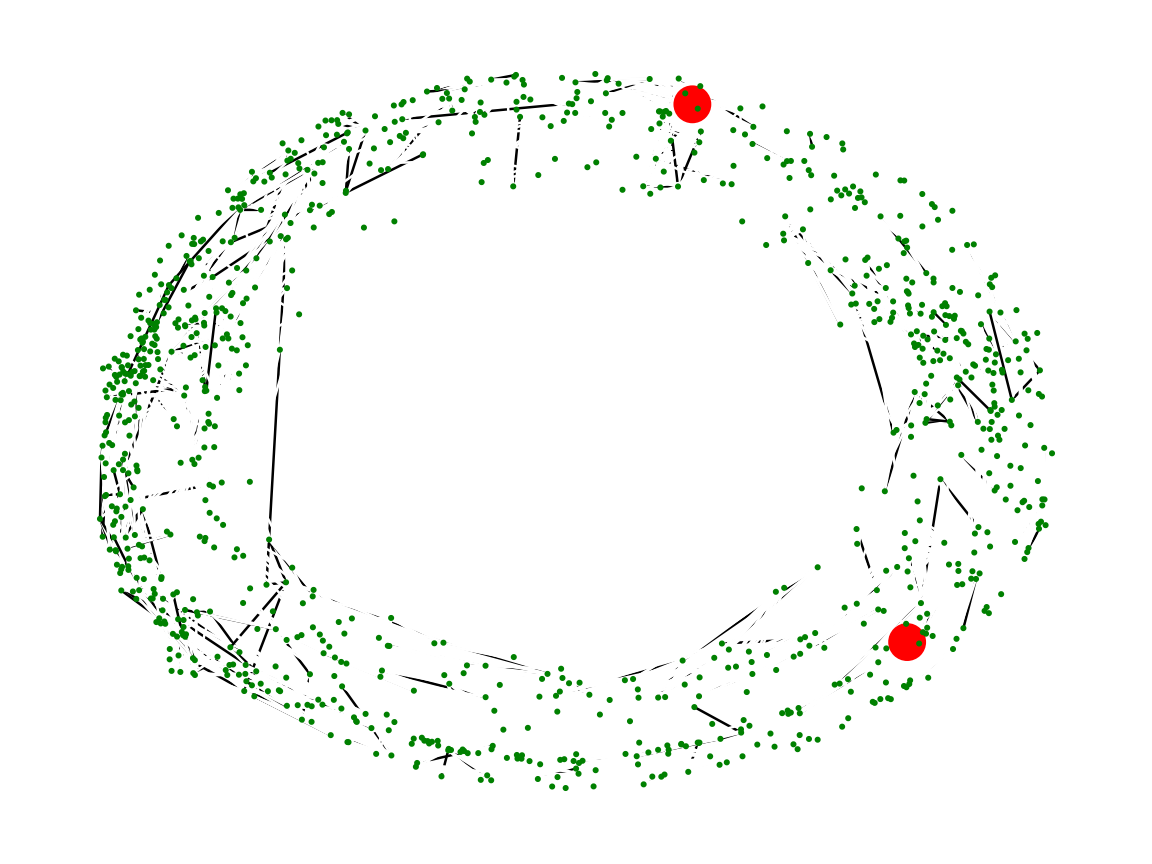

In [39]:
%matplotlib notebook
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

edge_color = (edge_score > -0.001).astype('float32')
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)
